### 1. Load data with real estate prices

In [1]:
# let's import pandas library and set options to be able to view data right in the browser
import joblib
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')
import numpy as np

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 

In [2]:
rent_df_cleaned = pd.read_csv('cleaned_dataset_my.csv')

In [3]:
rent_df_cleaned.head()

,offer_id,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,unified_address,building_id,price_per_sq_m,house_price_sqm_median
0,1100202,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,714.285714,512.820513
1,5028522699704970725,40000.0,4,0,2,0,72.0,10.0,44.0,0.0,"Россия, Санкт-Петербург, набережная реки Фонтанки, 66",3406104650917898355,555.555556,675.675676
2,5028522699709767236,45000.0,2,0,2,0,55.0,10.0,33.0,0.0,"Россия, Санкт-Петербург, Большой проспект П.С., 102",2357095685903407888,818.181818,818.181818
3,1100874,21000.0,5,0,1,0,35.0,8.0,18.0,11.0,"Россия, Санкт-Петербург, Лужская улица, 8",5887402119500981764,600.000000,568.468556
4,875413,25000.0,10,0,1,1,44.0,15.0,18.0,10.0,"Россия, Санкт-Петербург, Учительская улица, 3",6527910144166454997,568.181818,625.000000


In [4]:
rent_df_cleaned['renovation'] = rent_df_cleaned['renovation'].astype(int)

In [5]:
rent_df_cleaned = rent_df_cleaned.drop(['offer_id', 'unified_address', 'kitchen_area' , 'living_area','building_id', 'price_per_sq_m','house_price_sqm_median'], axis=1)

In [6]:
rent_df_cleaned.head()

,last_price,floor,open_plan,rooms,studio,area,renovation
0,20000.0,7,0,1,0,28.0,3
1,40000.0,4,0,2,0,72.0,0
2,45000.0,2,0,2,0,55.0,0
3,21000.0,5,0,1,0,35.0,11
4,25000.0,10,0,1,1,44.0,10


In [7]:
rent_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155392 entries, 0 to 155391
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   last_price  155392 non-null  float64
 1   floor       155392 non-null  int64  
 2   open_plan   155392 non-null  int64  
 3   rooms       155392 non-null  int64  
 4   studio      155392 non-null  int64  
 5   area        155392 non-null  float64
 6   renovation  155392 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 8.3 MB


In [8]:
# Percentage of Missing Values by Column
round(rent_df_cleaned.isna().mean() * 100, 2)

last_price    0.0
floor         0.0
open_plan     0.0
rooms         0.0
studio        0.0
area          0.0
renovation    0.0
dtype: float64

In [9]:
# Number of Duplicated Rows
rent_df_cleaned.duplicated().sum()

78924

In [10]:
rent_df_cleaned = rent_df_cleaned.drop_duplicates() 

In [11]:
# Number of Duplicated Rows
rent_df_cleaned.duplicated().sum()

0

In [12]:
# function for constructing a histogram of a feature
def bar_chart(column, title):
    fig, ax = plt.subplots(figsize=(9, 7))
    pivot = pd.DataFrame(rent_df_cleaned.pivot_table(index=column, 
                                          aggfunc="size").sort_values(ascending=False)).head(15)
    sns.barplot(data = pivot, x = pivot.index, y = 0)
    plt.title(title, fontsize = 15, pad = 17)
    plt.xticks(rotation = 45)
    plt.ylabel('Quantity', labelpad = 10)
    plt.show()

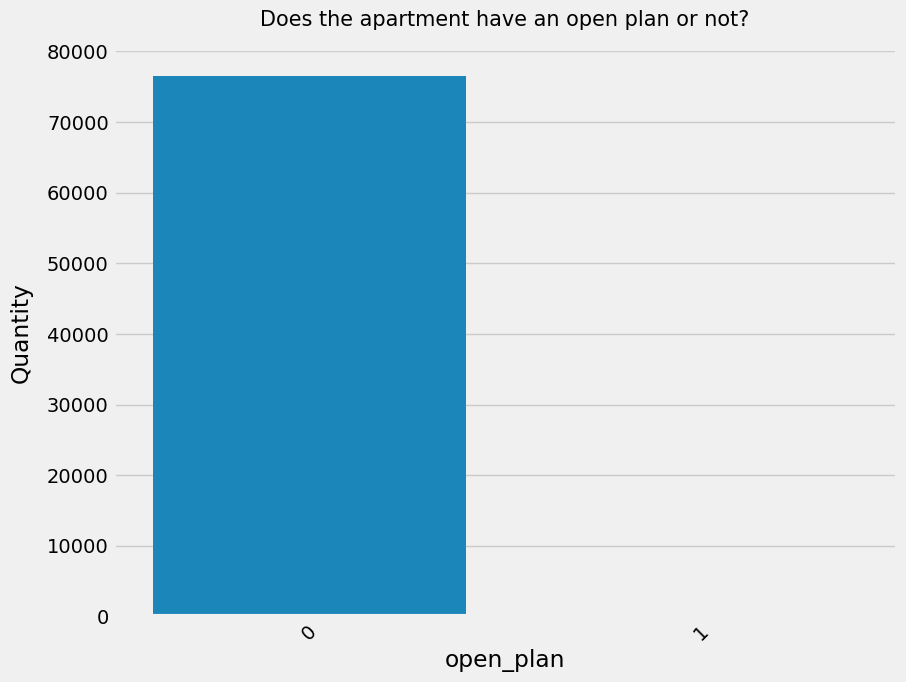

In [13]:
bar_chart('open_plan', 'Does the apartment have an open plan or not?')

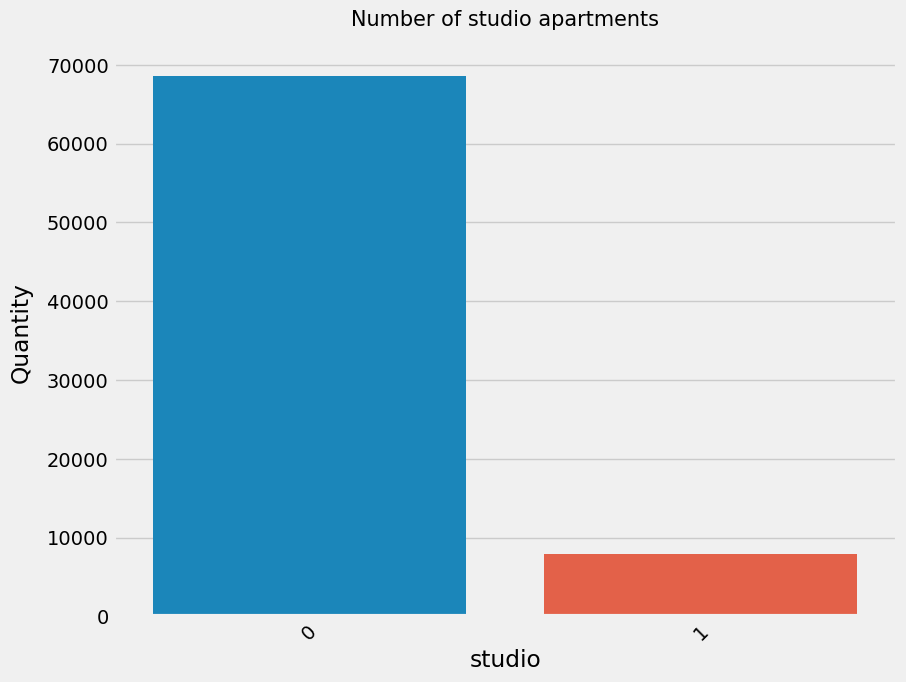

In [14]:
bar_chart('studio', 'Number of studio apartments')

**Last price**

count     76468.000000
mean      35961.282393
std       24546.772762
min        9990.000000
25%       21000.000000
50%       28000.000000
75%       40000.000000
max      199000.000000
Name: last_price, dtype: float64

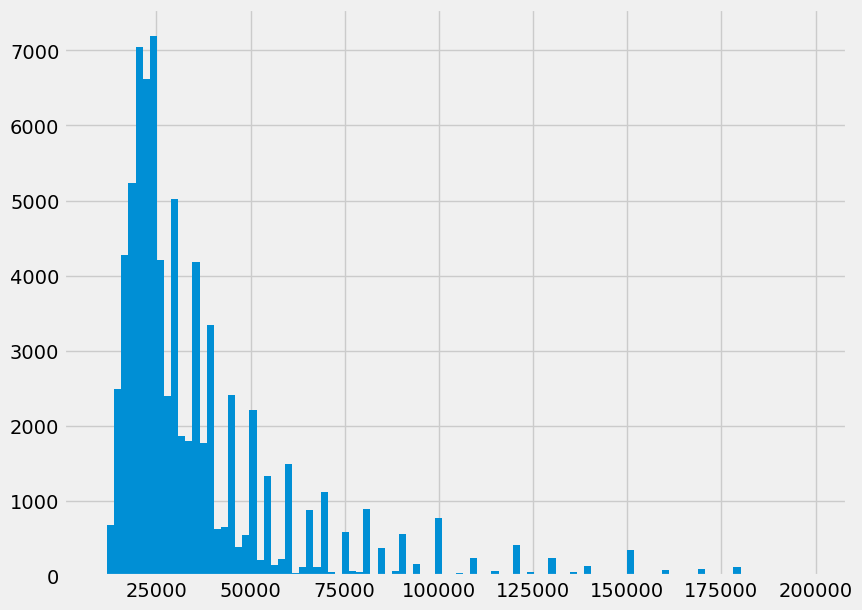

In [15]:
rent_df_cleaned['last_price'].hist(bins=100, figsize=(9,7))
rent_df_cleaned['last_price'] .describe()

In [16]:
# Function to eliminate anomalies (lower and upper bound)
def anomaly_2 (data, colomn):
    anomaly_min = round(data[colomn].quantile(0.01),2) 
    anomaly_max = round(data[colomn].quantile(0.99),2)
    print('Нижняя граница выбросов', colomn,':',anomaly_min)
    print('Верхняя граница выбросов', colomn,':',anomaly_max)
    return data.loc[(data[colomn] >= anomaly_min) & (data[colomn] <= anomaly_max)]

In [17]:
# Remove anomalous values
rent_df_cleaned = anomaly_2 (rent_df_cleaned, 'last_price')

Нижняя граница выбросов last_price : 14000.0
Верхняя граница выбросов last_price : 145000.0


**Floor**

count    75022.000000
mean         7.570806
std          5.611963
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         92.000000
Name: floor, dtype: float64

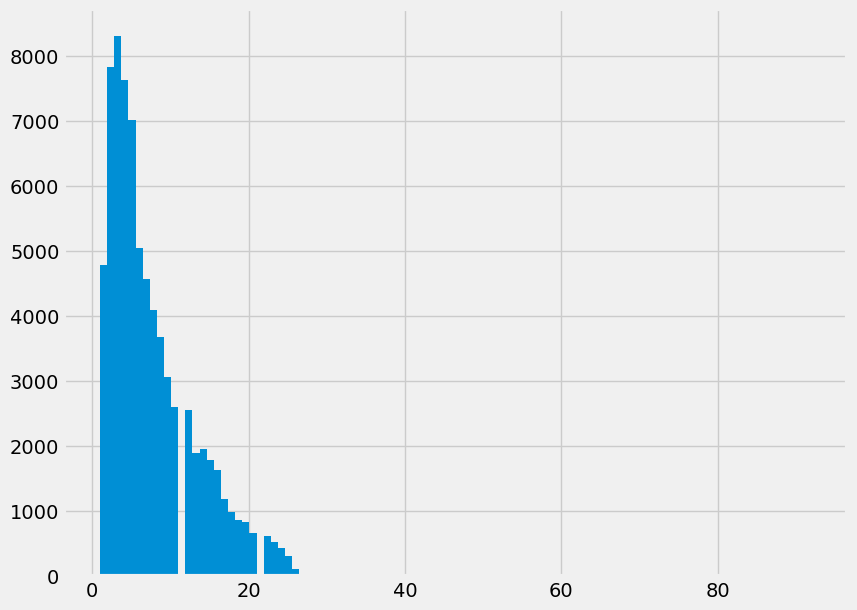

In [18]:
rent_df_cleaned['floor'].hist(bins=100, figsize=(9,7))
rent_df_cleaned['floor'] .describe()

In [19]:
# Remove anomalous values
rent_df_cleaned = anomaly_2 (rent_df_cleaned, 'floor')

Нижняя граница выбросов floor : 1.0
Верхняя граница выбросов floor : 24.0


**rooms**

count    74515.000000
mean         1.705563
std          0.993740
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: rooms, dtype: float64

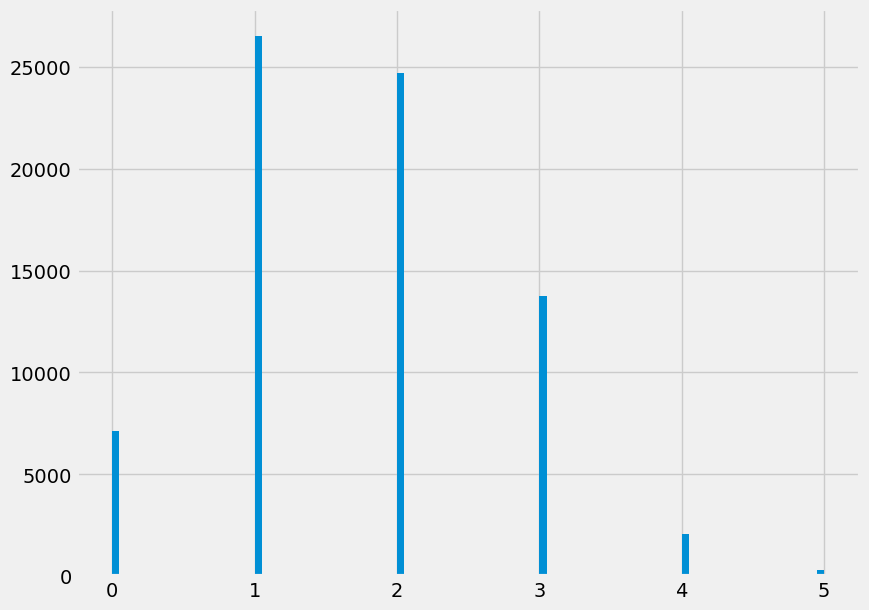

In [20]:
rent_df_cleaned['rooms'].hist(bins=100, figsize=(9,7))
rent_df_cleaned['rooms'] .describe()

**Area**

count    74515.000000
mean        58.111152
std         27.019167
min         11.000000
25%         39.000000
50%         52.000000
75%         70.000000
max        200.000000
Name: area, dtype: float64

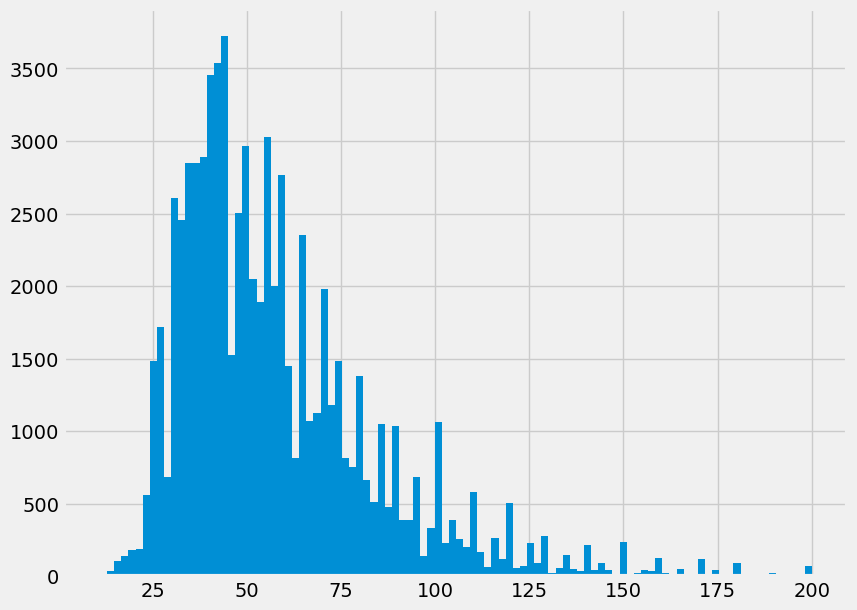

In [21]:
rent_df_cleaned['area'].hist(bins=100, figsize=(9,7))
rent_df_cleaned['area'] .describe()

In [22]:
# Remove anomalous values
rent_df_cleaned = anomaly_2 (rent_df_cleaned, 'area')

Нижняя граница выбросов area : 23.0
Верхняя граница выбросов area : 153.0


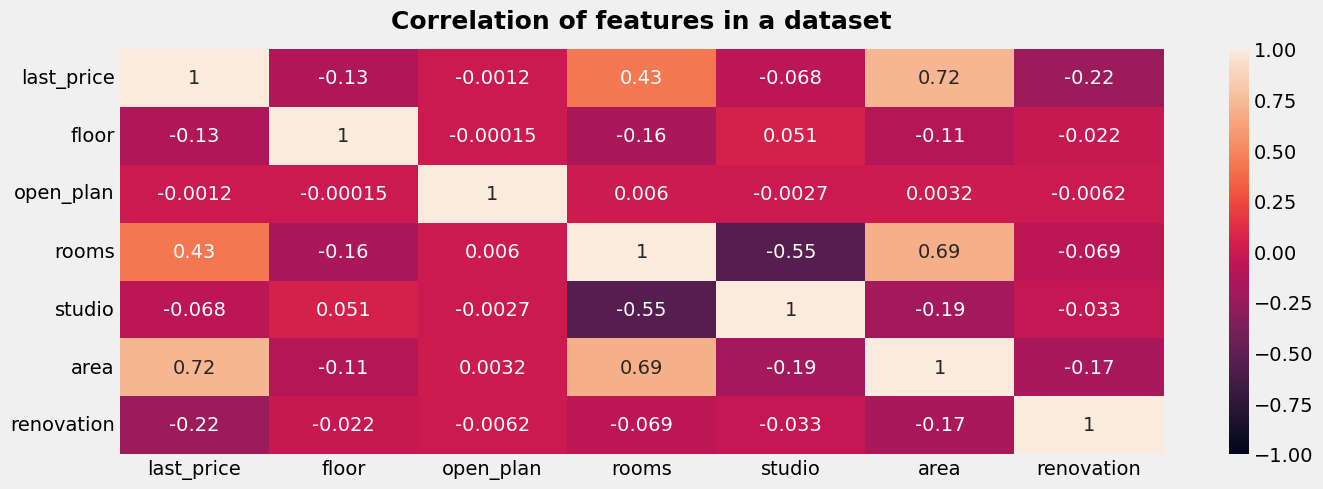

In [23]:
plt.figure(figsize = (15, 5)) 
sns.heatmap(rent_df_cleaned.corr(), annot = True, vmin=-1, vmax=1)
plt.title('Correlation of features in a dataset', fontweight = "bold", fontsize = 18, pad = 15)
plt.show();

### Create datasets training, testing and a holdout dataset.

In [24]:
features = rent_df_cleaned.drop('last_price', axis=1)
target = rent_df_cleaned['last_price']

# It is necessary to split the data into a training and validation set
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size = 0.40, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size = 0.50, random_state = 12345)

In [25]:
print(f'Training set size:')
display(features_train.shape)
display(target_train.shape)

print(f'Validation set size:')
display(features_valid.shape)
display(target_valid.shape)

print(f'Test set size:')
display(features_test.shape)
display(target_test.shape)

Training set size:


(43862, 6)

(43862,)

Validation set size:


(14621, 6)

(14621,)

Test set size:


(14621, 6)

(14621,)

In [26]:
sc_X = StandardScaler()
sc_y = StandardScaler()

features_train = sc_X.fit_transform(features_train)
features_valid = sc_X.fit_transform(features_valid)
features_test = sc_X.fit_transform(features_test)
target_train= target_train.values.reshape(-1,1)
target_valid= target_valid.values.reshape(-1,1)
target_test= target_test.values.reshape(-1,1)
target_train = sc_y.fit_transform(target_train)
target_valid = sc_y.fit_transform(target_valid)
target_test = sc_y.fit_transform(target_test)

### Model training

#### LinearRegression

In [27]:
model_lr = LinearRegression(n_jobs = -1)
model_lr.fit(features_train, target_train)

LinearRegression(n_jobs=-1)

In [28]:
prediction_lr = model_lr.predict(features_valid)

In [29]:
MAE_lr = metrics.mean_absolute_error(target_valid, prediction_lr)
RMSE_lr = np.sqrt(metrics.mean_squared_error(target_valid, prediction_lr))
MAPE_lr = metrics.mean_absolute_percentage_error(target_valid, prediction_lr)

In [30]:
model_characteristics = {
    'LinearRegression': {
        'MAE': MAE_lr,
        'RSME': RMSE_lr,
        'MAPE': MAPE_lr
    },
}
info = pd.DataFrame(model_characteristics).T
info

,MAE,MAPE,RSME
LinearRegression,0.459576,1.943975,0.67022


#### DecisionTreeRegressor

In [31]:
modeldtr = DecisionTreeRegressor()
params = {
    'splitter' : ['best', 'random'],
    'random_state' : [42],
    'max_depth' : np.arange(1, 40)
}
grid_cvd = GridSearchCV(estimator = modeldtr, param_grid = params, cv=3, n_jobs = -1, scoring='neg_mean_squared_error')

In [32]:
%%time

grid_cvd.fit(features_train, target_train)
dtr_params = grid_cvd.best_params_
print('f Best hyperparams: ', grid_cvd.best_params_)
print(f'RMSE score on train sample: {round((-grid_cvd.best_score_) ** 0.5, 2)}\n')

f Best hyperparams:  {'max_depth': 7, 'random_state': 42, 'splitter': 'best'}
RMSE score on train sample: 0.66

CPU times: user 185 ms, sys: 59.3 ms, total: 244 ms
Wall time: 3.62 s


In [33]:
model_DTR = DecisionTreeRegressor(max_depth = 7, splitter = 'best', 
                                 random_state = 42)

In [34]:
model_DTR.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [35]:
prediction_rt = model_DTR.predict(features_valid)

In [36]:
MAE_rt = metrics.mean_absolute_error(target_valid, prediction_rt)
RMSE_rt = np.sqrt(metrics.mean_squared_error(target_valid, prediction_rt))
MAPE_rt = metrics.mean_absolute_percentage_error(target_valid, prediction_rt)

In [37]:
model_characteristics['DecisionTreeRegressor'] = {
        'MAE': MAE_rt,
        'RSME': RMSE_rt,
        'MAPE': MAPE_rt
}
info = pd.DataFrame(model_characteristics).T
info

,MAE,RSME,MAPE
LinearRegression,0.459576,0.670220,1.943975
DecisionTreeRegressor,0.432542,0.654643,1.854914


#### CatBoostRegressor

In [38]:
model = CatBoostRegressor()
params = {
    'n_estimators' : [500, 800, 1000],
    'learning_rate': [0.03, 0.1],
    'random_state' : [42],
    'max_depth' : [5, 7, 10, 12],
    'verbose':[0]
}
grid_cv = GridSearchCV(estimator = model, param_grid = params, cv=3, n_jobs = -1, scoring='neg_mean_squared_error')

In [39]:
%%time

grid_cv.fit(features_train, target_train)
cat_params = grid_cv.best_params_
print('f Best hyperparams: ', grid_cv.best_params_)
print(f'RMSE score on train sample: {round((-grid_cv.best_score_) ** 0.5, 2)}\n')

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


f Best hyperparams:  {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 500, 'random_state': 42, 'verbose': 0}
RMSE score on train sample: 0.64

CPU times: user 3.82 s, sys: 233 ms, total: 4.06 s
Wall time: 4min 27s


In [40]:
model_CB = CatBoostRegressor(learning_rate = 0.03, max_depth = 5, n_estimators = 500, random_state = 42, 
                             verbose = 0)
model_CB.fit(features_train, target_train)

In [41]:
predictions_CB = model_CB.predict(features_valid)

In [42]:
MAE_cat = metrics.mean_absolute_error(target_valid, predictions_CB)
RMSE_cat = np.sqrt(metrics.mean_squared_error(target_valid, predictions_CB))
MAPE_cat = metrics.mean_absolute_percentage_error(target_valid, predictions_CB)

In [43]:
model_characteristics['CatBoostRegressor'] = {
        'MAE': MAE_cat,
        'RSME': RMSE_cat,
        'MAPE': MAPE_cat
    }
info = pd.DataFrame(model_characteristics).T
info

,MAE,RSME,MAPE
LinearRegression,0.459576,0.670220,1.943975
DecisionTreeRegressor,0.432542,0.654643,1.854914
CatBoostRegressor,0.426540,0.641263,1.828946


#### LightGBM

In [44]:
model_LGBM = LGBMRegressor()
params = {
    'metric': ['l2'],
    'max_depth':np.arange(1, 10),
    'n_estimators':np.arange(100, 1600, 100),
    'boosting_type': ['gbdt'],
    'num_leaves': [128],
    'random_state' : [42],
}
grid_LGBM = GridSearchCV(estimator = model_LGBM, param_grid = params, cv=3, n_jobs = -1, scoring='neg_mean_squared_error')

In [45]:
#%%time

#grid_LGBM.fit(features_train, target_train)
#LGBM_params = grid_LGBM.best_params_
#print('f Best hyperparams: ', grid_LGBM.best_params_)
#print(f'RMSE score on train sample: {round((-grid_LGBM.best_score_) ** 0.5, 2)}\n')

In [46]:
model_LGBM = LGBMRegressor(boosting_type = 'gbdt', max_depth = 4, n_estimators = 100, random_state = 42, metric = 'l2', 
                             num_leaves = 128)
model_LGBM.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 43862, number of used features: 5
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(max_depth=4, metric='l2', num_leaves=128, random_state=42)

In [47]:
predictions_LGBM = model_LGBM.predict(features_valid)

In [48]:
MAE_LGBM = metrics.mean_absolute_error(target_valid, predictions_LGBM)
RMSE_LGBM = np.sqrt(metrics.mean_squared_error(target_valid, predictions_LGBM))
MAPE_LGBM = metrics.mean_absolute_percentage_error(target_valid, predictions_LGBM)

In [49]:
model_characteristics['LGBMRegressor'] = {
        'MAE': MAE_LGBM,
        'RSME': RMSE_LGBM,
        'MAPE': MAPE_LGBM
    }
info = pd.DataFrame(model_characteristics).T
info

,MAE,RSME,MAPE
LinearRegression,0.459576,0.670220,1.943975
DecisionTreeRegressor,0.432542,0.654643,1.854914
CatBoostRegressor,0.426540,0.641263,1.828946
LGBMRegressor,0.425663,0.641956,1.830472


### Model testing

In [50]:
best_model = model_DTR
best_model.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [51]:
prediction_best = best_model.predict(features_test)

In [52]:
MAE = metrics.mean_absolute_error(target_test, prediction_best)
RMSE = np.sqrt(metrics.mean_squared_error(target_test, prediction_best))
MAPE = metrics.mean_absolute_percentage_error(target_test, prediction_best)

In [53]:
model_characteristics['Test_model_DTR'] = {
        'MAE': MAE,
        'RSME': RMSE,
        'MAPE': MAPE
    }
info = pd.DataFrame(model_characteristics).T
info

,MAE,RSME,MAPE
LinearRegression,0.459576,0.670220,1.943975
DecisionTreeRegressor,0.432542,0.654643,1.854914
CatBoostRegressor,0.426540,0.641263,1.828946
LGBMRegressor,0.425663,0.641956,1.830472
Test_model_DTR,0.433786,0.655683,1.671722


In [54]:
model_file = 'model.pkl'
scaler_x = 'scaler_x.pkl'
scaler_y = 'scaler_y.pkl'
joblib.dump(sc_X, scaler_x)
joblib.dump(sc_y, scaler_y)
joblib.dump(model_DTR, model_file)

['model.pkl']